In [1]:
import os
import time
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, CuDNNLSTM
from keras.optimizers import Adam
from keras import backend as K
import time as t_lib
import tensorflow as tf
from threading import Thread
from IPython.display import clear_output
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
DATAFRAME_NAME = 'EURUSD_m15_Ask_ready.csv'
NUMBER_OF_SAMPLES = 20

EPISODES = 5000
TICQTY_MAX = 55000
HOLD_REWARD = -50
OPEN_TRADE_REWARD = 0
CLOSING_TRADE_WITH_OPENING = 0  #20
DIVIDE_PRICE_UNDER_LOCAL_MINIMA = 1  #10
REWARD_FOR_PIPS = 10000
TIMES_FACTOR = 10 #10
NEGATIVE_REWARD_DIVIDE = 3 # kolikrat bude mensi times factor pri zaporne odmene

ACTION_DECODE = {
    0: 0,
    1: 0.5,
    2: 1,
}

osmdesat = 35

In [3]:
class Dataframe:

    def __init__(self):
        self._dataframe = self._load()[0:2000]
        self.__scaler = MinMaxScaler()

    @property
    def lenght(self):
        return len(self._dataframe.index) - NUMBER_OF_SAMPLES

    def get(self, sample_number):
        if sample_number > self.lenght or sample_number < 0:
            raise ValueError("Sample number out of range (0 - {self.lenght})")

        start_index = sample_number
        end_index = start_index + NUMBER_OF_SAMPLES

        df_sample = self._dataframe[start_index: end_index]

        last_open = df_sample.at[df_sample.index[-1], 'open']
        last_close = df_sample.at[df_sample.index[-1], 'close']

        df_sample = df_sample[['open', 'close', 'high', 'low', 'tickqty', 'hours', 'minutes']].values
        df_sample = self._scale(df_sample, start=0, end=4)
        return np.expand_dims(df_sample, axis=0), last_open, last_close

    @staticmethod
    def _load():
        """ Creating relative path and then loading the df_path """
        """
        df_path = os.path.join(os.path.dirname(os.path.abspath(__file__)) +
                               os.path.normpath(f'/dfs/{cfg.DATAFRAME_NAME}'))
        """
        df_path = './dfs/{}'.format(DATAFRAME_NAME)
        df = pd.read_csv(
            df_path,
            dtype={
                'datetime'
                'open': np.float32,
                'close': np.float32,
                'high': np.float32,
                'low': np.float32,
                'tickqty': np.float32,
            }
        )

        # df['hours']= pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S.%f').dt.hour / 24
        df['hours'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.hour / 24
        df['minutes'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.minute / 64
        df['tickqty'] = df['tickqty'] / TICQTY_MAX
        return df

    def _scale(self, array: np.ndarray, start: int, end: int):
        columns = array.T[start: end].T

        self.__scaler.fit(columns)
        scaled_cols = self.__scaler.transform(columns).T
        array.T[start:end] = scaled_cols
        return array

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.sample_memory = deque()
        
        self.gamma = 0.99  # discount rate
        
        self.epsilon = 0.15  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.9998
        
        self.learning_rate = 0.00083
        self.learning_rate_decay = 0.9999
        self.learning_rate_min = 0.0001
        
        self.batch_size_samples = 500
        self.batch_size = batch_size
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    """Huber loss for Q Learning

    References: https://en.wikipedia.org/wiki/Huber_loss
                https://www.tensorflow.org/api_docs/python/tf/losses/huber_loss
    """

    def _huber_loss(self, y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond = K.abs(error) <= clip_delta

        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        """
        model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))
        """
        model.add(CuDNNLSTM(units=76, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=50, return_sequences=True)) 
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))  
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))
        
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        self.sample_memory.append((state, action, reward, next_state, done))
    
    def train_from_iterations(self):
        while True:
            if len(self.sample_memory) != 0:
                state, action, reward, next_state, done = self.sample_memory.popleft()
                self.train(state, action, reward, next_state, done)

    def train(self, state, action, reward, next_state, done):
        target = self.model.predict(state, steps=1, verbose=0)
        if done and reward > osmdesat * TIMES_FACTOR:
            target[0][action] = reward
        else:
            # a = self.model.predict(next_state)[0]
            t = self.target_model.predict(next_state)[0]
            target[0][action] = reward + self.gamma * np.amax(t)
            # target[0][action] = reward + self.gamma * t[np.argmax(a)]
        self.model.fit(state, target, epochs=1, verbose=0)
        # print('done')

    def act(self, state):
        if not isinstance(state, np.ndarray):
            return 0

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size), True
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0]), False  # returns action

    def predict(self, state):
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0])  # returns action

    def replay(self):
        while True:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                if not isinstance(state, np.ndarray):
                    continue
                
                self.train(state, action, reward, next_state, done)
                """
                target = self.model.predict(state, steps=1, verbose=0)
                if done and reward > 80 * TIMES_FACTOR:
                    target[0][action] = reward
                else:
                    # a = self.model.predict(next_state)[0]
                    t = self.target_model.predict(next_state)[0]
                    target[0][action] = reward + self.gamma * np.amax(t)
                    # target[0][action] = reward + self.gamma * t[np.argmax(a)]
                self.model.fit(state, target, epochs=1, verbose=0)
                """
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            else:
                self.epsilon = self.epsilon_min
            
            if self.learning_rate > self.learning_rate_min:
                self.learning_rate *= self.learning_rate_decay
            else:
                self.learning_rate = self.learning_rate_min
            # print('done')
    
    def set_learning_rate(self):
        K.set_value(self.model.optimizer.lr, self.learning_rate)  # set new lr
        K.set_value(self.target_model.optimizer.lr, self.learning_rate)  # set new lr

    def load(self, name):
        self.model.load_weights(name)
        self.model._make_predict_function()
        self.model._make_test_function()
        self.model._make_train_function()

        self.target_model.load_weights(name)
        self.target_model._make_predict_function()
        self.target_model._make_test_function()
        self.target_model._make_train_function()

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
class Trevor:
    POSITIVE_TIMES_REWARD = 0 #0.00001
    NEGATIVE_TIMES_REWARD = 0 #0.00001

    def __init__(self, df):
        self.df = df

        self.cursor = 0
        self.enter_price = 0
        self.local_max_price = 0

        self.last_action = 0

        self.closed_counter = 0
        self.total_reward = 0
        self.trade_counter = 0

        self.closed_counter_list = []

    def reset(self):
        self.cursor = 0
        self.enter_price = 0
        self.last_action = 0
        self.closed_counter = 0
        self.trade_counter = 0
        self.total_reward = 0
        # self.reset_closed_list()

        return self.step(0)[0]

    def step(self, action):
        sample, last_open, last_close = self.df.get(self.cursor)

        reward, closing_trade = self.__process_action(action=action, last_close=last_close)
        sample = self.__append_last_action(sample=sample, action=action, last_close=last_close)

        self.__increment_cursor()

        return sample, reward, closing_trade, ''

    def get_total_reward(self):
        return self.total_reward

    def reset_closed_list(self):
        self.closed_counter_list = []

    def plot(self, title):
        x = list(range(1, len(self.closed_counter_list) + 1))
        pyplot.plot(x, self.closed_counter_list)
        pyplot.title(str(title))
        pyplot.show()

    def __process_action(self, action, last_close):
        if action < 0 or action > 2:
            raise ValueError('Action have to be inrage (0 - 2) got {action}')

        closing_trade = False

        # """ CLOSING POSITION """
        if (self.last_action == 2 and action == 0) or (self.last_action == 1 and action == 0):
            reward = self.__close_trade(last_close=last_close)
            closing_trade = True

        # """ CLOSING POSITION AND GOING TO DIFFERENT POSITION """
        elif (self.last_action == 2 and action == 1) or (self.last_action == 1 and action == 2):
            reward = self.__close_trade(last_close=last_close) - CLOSING_TRADE_WITH_OPENING
            self.enter_price = last_close
            self.local_max_price = last_close
            closing_trade = True

        # """ HOLDING OPENED POSITION  """
        elif (self.last_action == 2 and action == 2) or (self.last_action == 1 and action == 1):
            if self.last_action == 2:
                if self.local_max_price < last_close:
                    reward = (last_close - self.enter_price) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (last_close - self.local_max_price) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close > self.enter_price \
                        else reward

            else:
                if self.local_max_price > last_close:
                    reward = (self.enter_price - last_close) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (self.local_max_price - last_close) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close < self.enter_price \
                        else reward

        # """ OPENING POSITION  """
        elif (self.last_action == 0 and action == 1) or (self.last_action == 0 and action == 2):
            self.enter_price = last_close
            self.local_max_price = last_close
            reward = OPEN_TRADE_REWARD

        # """ HOLD """
        elif self.last_action == 0 and action == 0:
            reward = HOLD_REWARD

        else:
            raise ValueError('Last action = {self.last_action} and actual_action = {action}')

        self.last_action = action
        self.total_reward += reward
        return reward, closing_trade

    def __increment_cursor(self):
        """ Incrementing the cursor, if the cursor is bigger than lenght of the dataframe, then reset it"""

        self.cursor += 1
        if self.cursor > self.df.lenght:
            self.cursor = 0

    def __close_trade(self, last_close):
        if self.last_action == 2:
            reward = (last_close - self.enter_price) * REWARD_FOR_PIPS 
            if reward < 0:
                reward = reward * (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
                self.closed_counter += reward / (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
            if reward > 0:
                reward = reward * TIMES_FACTOR
                self.closed_counter += reward / TIMES_FACTOR
            
            
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        else:
            reward = (self.enter_price - last_close) * REWARD_FOR_PIPS 
            if reward < 0:
                reward = reward * (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
                self.closed_counter += reward / (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
            if reward > 0:
                reward = reward * TIMES_FACTOR
                self.closed_counter += reward / TIMES_FACTOR
                
            
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        self.closed_counter_list.append(self.closed_counter)
        self.trade_counter += 1
        return reward

    def __append_last_action(self, sample: np.ndarray, action: int, last_close: float):
        how_many = sample.shape[1]
        decoded_action = ACTION_DECODE[action]

        action_arr = (np.expand_dims(np.asarray([decoded_action for i in range(0, how_many)]), axis=1))

        if action == 2 or action == 1:
            dif = (last_close - self.enter_price)
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        else:
            dif = 0
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        sample = np.append(sample[0], action_arr, axis=1)
        sample = np.append(sample, pip_difference, axis=1)

        return np.expand_dims(sample, axis=0)

C:\Users\Lukas\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
More than 35 on candle 12
More than 35 on candle 212
More than 35 on candle 506
More than 35 on candle 918


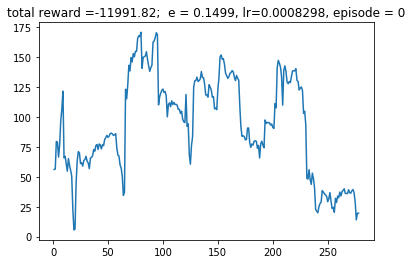

Waiting to train the whole dataset
action0:  241 
action1:  830 
action2:  909
DONE, lets roll!!
92.145
More than 35 on candle 115
More than 35 on candle 211
More than 35 on candle 291
More than 35 on candle 505
More than 35 on candle 1189
More than 35 on candle 1588


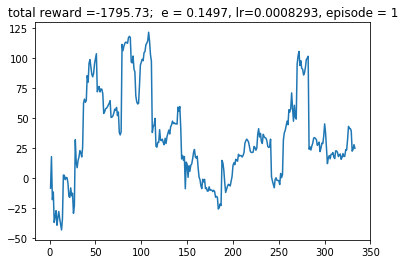

Waiting to train the whole dataset
action0:  147 
action1:  766 
action2:  1067
DONE, lets roll!!
93.343
More than 35 on candle 14
More than 35 on candle 36
More than 35 on candle 210
More than 35 on candle 718
More than 35 on candle 1670


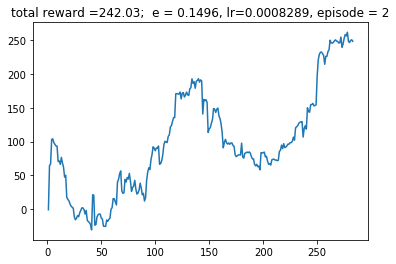

Waiting to train the whole dataset
action0:  138 
action1:  794 
action2:  1048
DONE, lets roll!!
89.645
More than 35 on candle 13
More than 35 on candle 1196


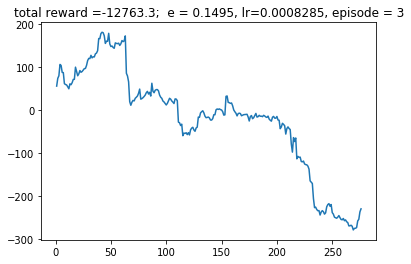

Waiting to train the whole dataset
action0:  252 
action1:  882 
action2:  846
DONE, lets roll!!
86.067
More than 35 on candle 67
More than 35 on candle 116
More than 35 on candle 704


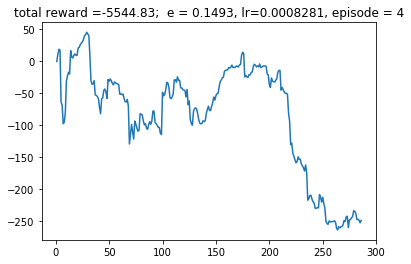

Waiting to train the whole dataset
action0:  169 
action1:  842 
action2:  969
DONE, lets roll!!
93.856
More than 35 on candle 523
More than 35 on candle 718
More than 35 on candle 876


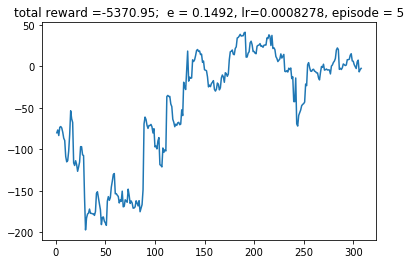

Waiting to train the whole dataset
action0:  193 
action1:  532 
action2:  1255
DONE, lets roll!!
85.408
More than 35 on candle 115
More than 35 on candle 510


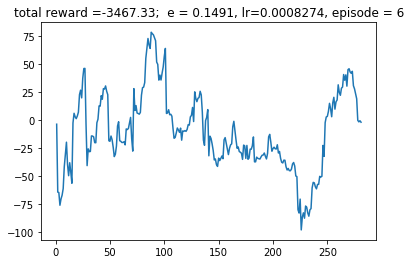

Waiting to train the whole dataset
action0:  148 
action1:  402 
action2:  1430
DONE, lets roll!!
94.105
More than 35 on candle 1686


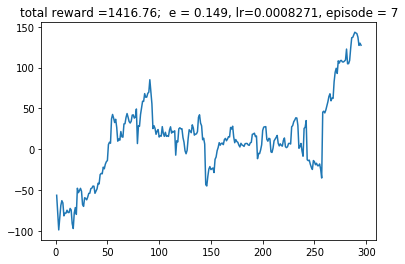

Waiting to train the whole dataset
action0:  104 
action1:  387 
action2:  1489
DONE, lets roll!!
87.359
More than 35 on candle 697
More than 35 on candle 1196


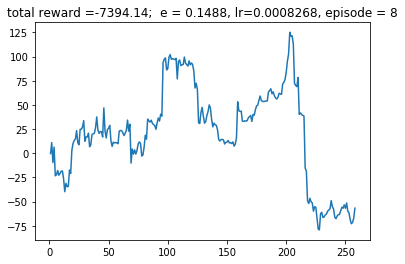

Waiting to train the whole dataset
action0:  230 
action1:  783 
action2:  967
DONE, lets roll!!
85.36
More than 35 on candle 123
More than 35 on candle 697
More than 35 on candle 1560
More than 35 on candle 1590


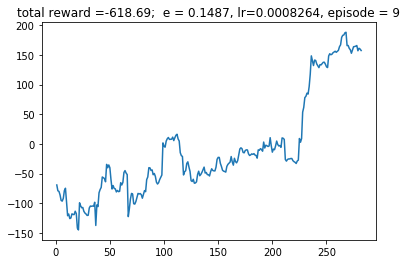

Waiting to train the whole dataset
action0:  169 
action1:  675 
action2:  1136
DONE, lets roll!!
91.311
More than 35 on candle 17
More than 35 on candle 117
More than 35 on candle 698
More than 35 on candle 906
More than 35 on candle 1562
More than 35 on candle 1965


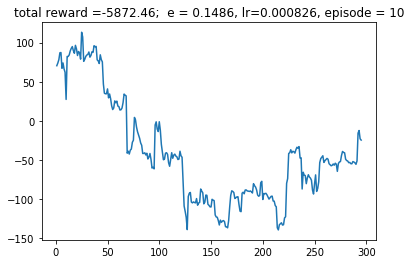

Waiting to train the whole dataset
action0:  200 
action1:  1182 
action2:  598
DONE, lets roll!!
88.128
More than 35 on candle 11
More than 35 on candle 509
More than 35 on candle 1558
More than 35 on candle 1674


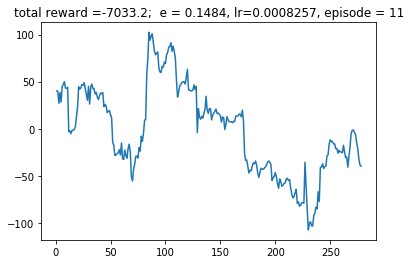

Waiting to train the whole dataset
action0:  219 
action1:  455 
action2:  1306
DONE, lets roll!!
85.123
More than 35 on candle 13
More than 35 on candle 532
More than 35 on candle 904
More than 35 on candle 1591


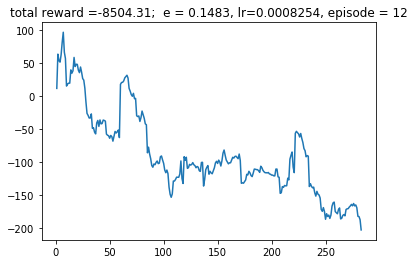

Waiting to train the whole dataset
action0:  243 
action1:  1009 
action2:  728
DONE, lets roll!!
88.251
More than 35 on candle 207
More than 35 on candle 506
More than 35 on candle 700
More than 35 on candle 1674


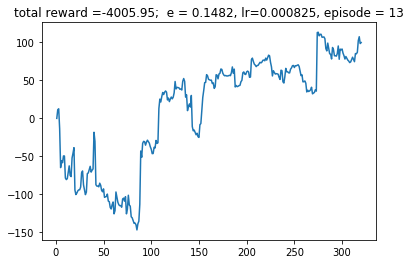

Waiting to train the whole dataset
action0:  193 
action1:  882 
action2:  905
DONE, lets roll!!
86.62
More than 35 on candle 215
More than 35 on candle 878
More than 35 on candle 912
More than 35 on candle 1570
More than 35 on candle 1588


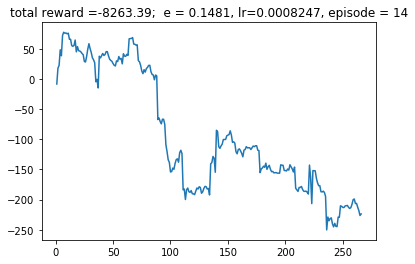

Waiting to train the whole dataset
action0:  162 
action1:  1018 
action2:  800
DONE, lets roll!!
87.03
More than 35 on candle 214
More than 35 on candle 884
More than 35 on candle 1671


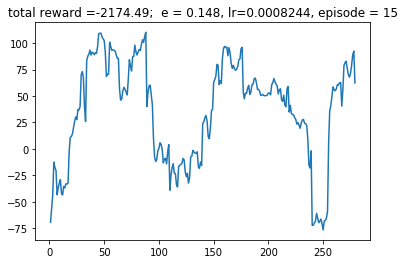

Waiting to train the whole dataset
action0:  155 
action1:  674 
action2:  1151
DONE, lets roll!!
90.172
More than 35 on candle 8
More than 35 on candle 208
More than 35 on candle 368
More than 35 on candle 718
More than 35 on candle 1588


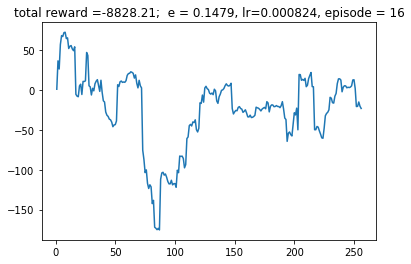

Waiting to train the whole dataset
action0:  199 
action1:  1134 
action2:  647
DONE, lets roll!!
91.049
More than 35 on candle 11
More than 35 on candle 55
More than 35 on candle 208
More than 35 on candle 703
More than 35 on candle 1201
More than 35 on candle 1673


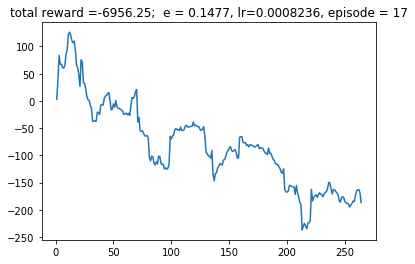

Waiting to train the whole dataset
action0:  164 
action1:  883 
action2:  933
DONE, lets roll!!
95.081
More than 35 on candle 18
More than 35 on candle 510
More than 35 on candle 697
More than 35 on candle 904
More than 35 on candle 1685


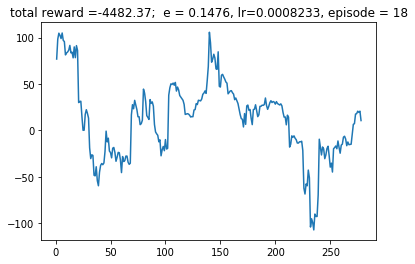

Waiting to train the whole dataset
action0:  195 
action1:  737 
action2:  1048
DONE, lets roll!!
90.503
More than 35 on candle 507
More than 35 on candle 1674


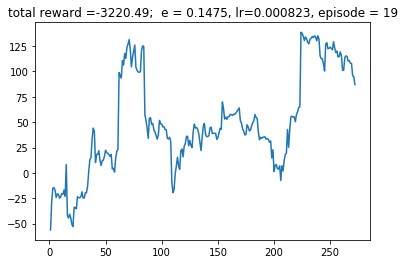

Waiting to train the whole dataset
action0:  159 
action1:  515 
action2:  1306
DONE, lets roll!!
89.927
More than 35 on candle 25
More than 35 on candle 333


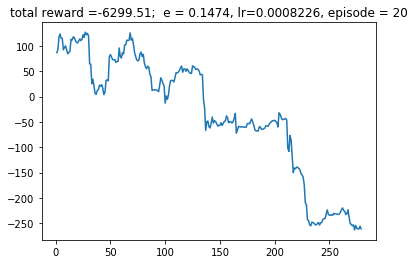

Waiting to train the whole dataset
action0:  151 
action1:  770 
action2:  1059
DONE, lets roll!!
92.92
More than 35 on candle 123
More than 35 on candle 208
More than 35 on candle 577
More than 35 on candle 1674


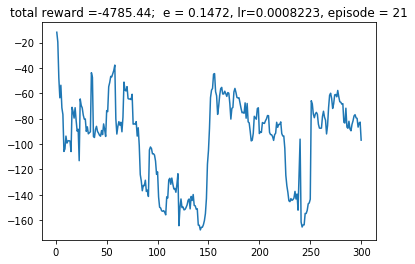

Waiting to train the whole dataset
action0:  164 
action1:  734 
action2:  1082
DONE, lets roll!!
95.763
More than 35 on candle 127
More than 35 on candle 714
More than 35 on candle 1556


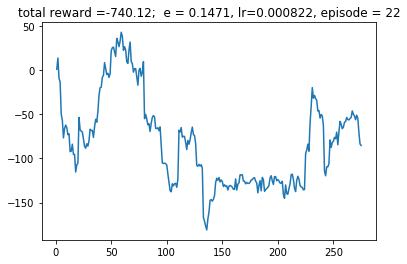

Waiting to train the whole dataset
action0:  110 
action1:  844 
action2:  1026
DONE, lets roll!!
102.27
More than 35 on candle 22
More than 35 on candle 1686


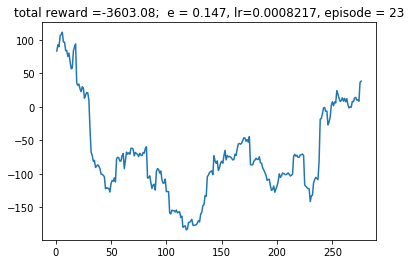

Waiting to train the whole dataset
action0:  174 
action1:  705 
action2:  1101
DONE, lets roll!!
206.719
More than 35 on candle 205
More than 35 on candle 212
More than 35 on candle 327
More than 35 on candle 505
More than 35 on candle 628
More than 35 on candle 1577
More than 35 on candle 1674


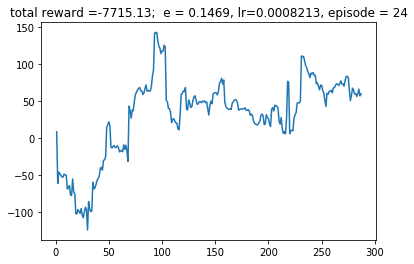

Waiting to train the whole dataset
action0:  197 
action1:  503 
action2:  1280
DONE, lets roll!!
209.553
More than 35 on candle 149
More than 35 on candle 206
More than 35 on candle 509


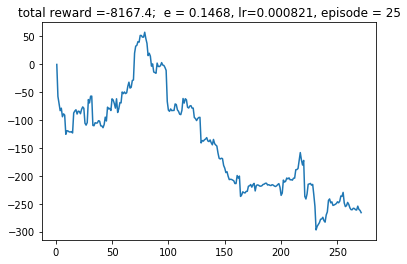

Waiting to train the whole dataset
action0:  183 
action1:  516 
action2:  1281
DONE, lets roll!!
206.607
More than 35 on candle 14
More than 35 on candle 210
More than 35 on candle 699
More than 35 on candle 1576


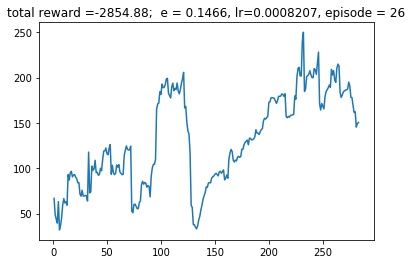

Waiting to train the whole dataset
action0:  142 
action1:  977 
action2:  861
DONE, lets roll!!
202.946
More than 35 on candle 709
More than 35 on candle 1591


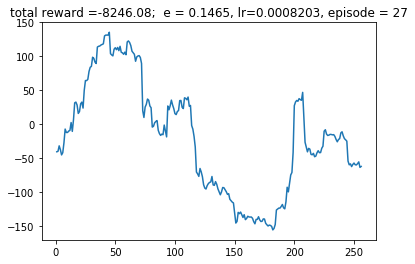

Waiting to train the whole dataset
action0:  231 
action1:  835 
action2:  914
DONE, lets roll!!
87.717
More than 35 on candle 16
More than 35 on candle 132
More than 35 on candle 207
More than 35 on candle 506
More than 35 on candle 886
More than 35 on candle 905
More than 35 on candle 1677


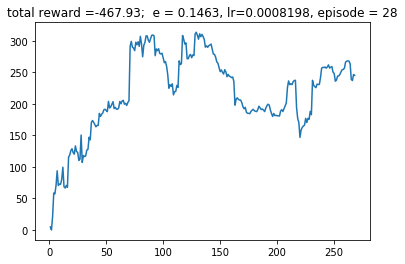

Waiting to train the whole dataset
action0:  188 
action1:  845 
action2:  947
DONE, lets roll!!
105.661
More than 35 on candle 709
More than 35 on candle 1672


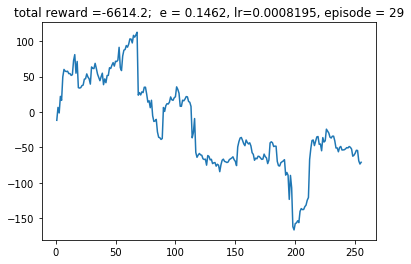

Waiting to train the whole dataset
action0:  170 
action1:  536 
action2:  1274
DONE, lets roll!!
81.012
More than 35 on candle 16
More than 35 on candle 210
More than 35 on candle 704


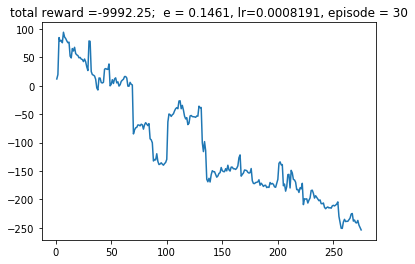

Waiting to train the whole dataset
action0:  186 
action1:  674 
action2:  1120
DONE, lets roll!!
102.984
More than 35 on candle 1191
More than 35 on candle 1573
More than 35 on candle 1685


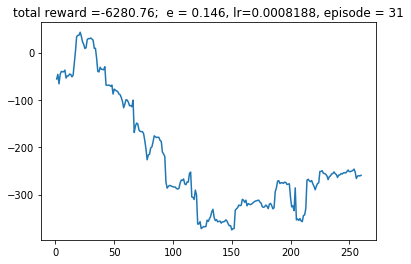

Waiting to train the whole dataset
action0:  137 
action1:  668 
action2:  1175
DONE, lets roll!!
96.984
More than 35 on candle 522
More than 35 on candle 887
More than 35 on candle 909
More than 35 on candle 1675


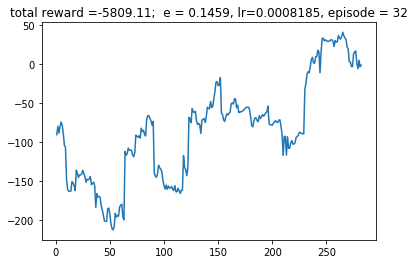

Waiting to train the whole dataset
action0:  209 
action1:  504 
action2:  1267
DONE, lets roll!!
95.841
More than 35 on candle 214
More than 35 on candle 308
More than 35 on candle 527
More than 35 on candle 705
More than 35 on candle 1584


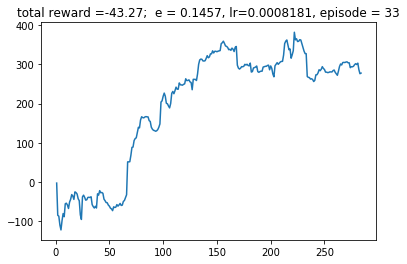

Waiting to train the whole dataset
action0:  170 
action1:  704 
action2:  1106
DONE, lets roll!!
90.228
More than 35 on candle 12
More than 35 on candle 504
More than 35 on candle 1587


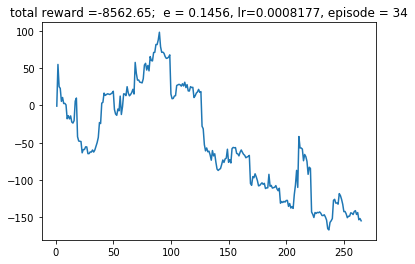

Waiting to train the whole dataset
action0:  183 
action1:  826 
action2:  971
DONE, lets roll!!
89.97
More than 35 on candle 22
More than 35 on candle 115
More than 35 on candle 207
More than 35 on candle 212
More than 35 on candle 313
More than 35 on candle 506
More than 35 on candle 1595


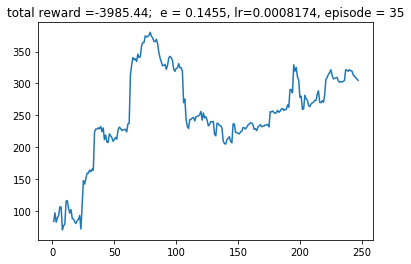

Waiting to train the whole dataset
action0:  190 
action1:  586 
action2:  1204
DONE, lets roll!!
91.5
More than 35 on candle 129
More than 35 on candle 727


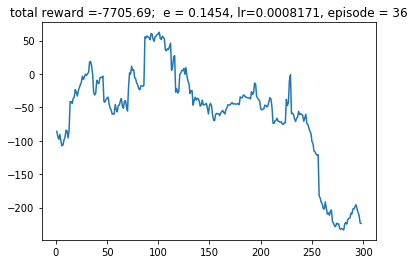

Waiting to train the whole dataset
action0:  200 
action1:  1014 
action2:  766
DONE, lets roll!!
93.864
More than 35 on candle 330
More than 35 on candle 718
More than 35 on candle 1192


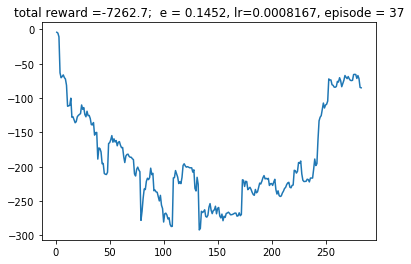

Waiting to train the whole dataset
action0:  242 
action1:  494 
action2:  1244
DONE, lets roll!!
88.583
More than 35 on candle 508
More than 35 on candle 888
More than 35 on candle 907
More than 35 on candle 1487
More than 35 on candle 1678


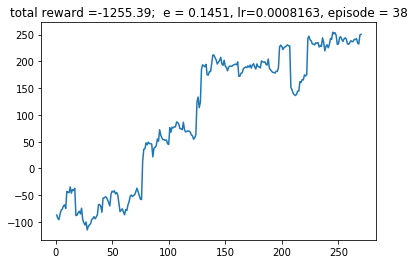

Waiting to train the whole dataset
action0:  85 
action1:  710 
action2:  1185
DONE, lets roll!!
93.037
More than 35 on candle 24
More than 35 on candle 209
More than 35 on candle 508


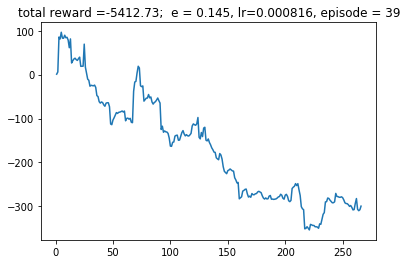

Waiting to train the whole dataset
action0:  148 
action1:  553 
action2:  1279
DONE, lets roll!!
89.074
More than 35 on candle 905
More than 35 on candle 1593
More than 35 on candle 1678


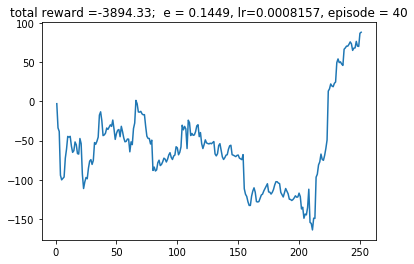

Waiting to train the whole dataset
action0:  187 
action1:  576 
action2:  1217
DONE, lets roll!!
87.882
More than 35 on candle 13
More than 35 on candle 225
More than 35 on candle 317
More than 35 on candle 520
More than 35 on candle 583
More than 35 on candle 1586


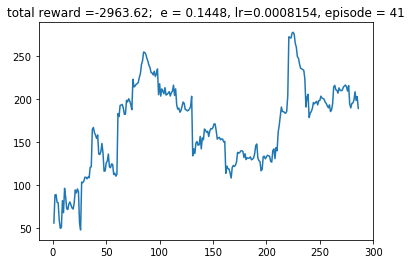

Waiting to train the whole dataset
action0:  221 
action1:  870 
action2:  889
DONE, lets roll!!
93.977
More than 35 on candle 216
More than 35 on candle 504
More than 35 on candle 714
More than 35 on candle 1606


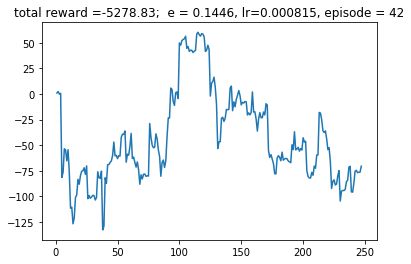

Waiting to train the whole dataset
action0:  166 
action1:  849 
action2:  965
DONE, lets roll!!
90.586
More than 35 on candle 117
More than 35 on candle 208
More than 35 on candle 878
More than 35 on candle 908
More than 35 on candle 1580
More than 35 on candle 1676


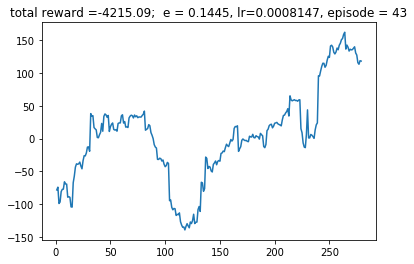

Waiting to train the whole dataset
action0:  198 
action1:  472 
action2:  1310
DONE, lets roll!!
93.335
More than 35 on candle 124
More than 35 on candle 218
More than 35 on candle 295
More than 35 on candle 505
More than 35 on candle 910
More than 35 on candle 1195


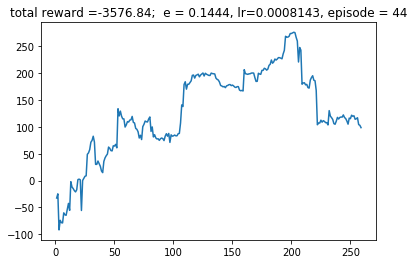

Waiting to train the whole dataset
action0:  146 
action1:  647 
action2:  1187
DONE, lets roll!!
100.581
More than 35 on candle 124
More than 35 on candle 517
More than 35 on candle 1599


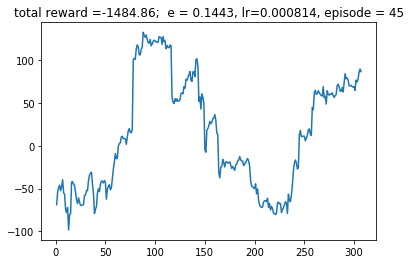

Waiting to train the whole dataset
action0:  158 
action1:  512 
action2:  1310
DONE, lets roll!!
87.17
More than 35 on candle 1700


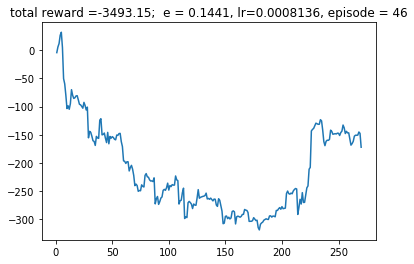

Waiting to train the whole dataset
action0:  170 
action1:  230 
action2:  1580
DONE, lets roll!!
86.244
More than 35 on candle 74
More than 35 on candle 117
More than 35 on candle 508


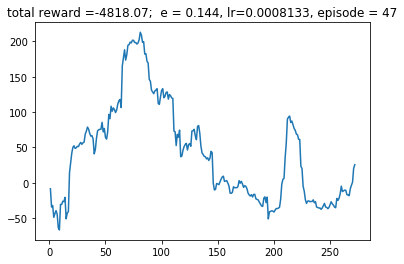

Waiting to train the whole dataset
action0:  157 
action1:  979 
action2:  844
DONE, lets roll!!
83.357
More than 35 on candle 546
More than 35 on candle 708
More than 35 on candle 913
More than 35 on candle 1561
More than 35 on candle 1675


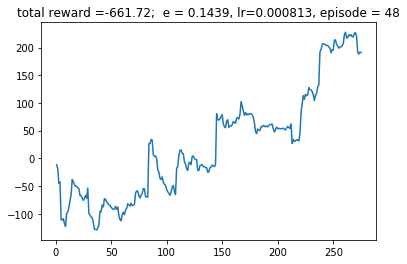

Waiting to train the whole dataset
action0:  152 
action1:  618 
action2:  1210
DONE, lets roll!!
91.012
More than 35 on candle 224
More than 35 on candle 1669


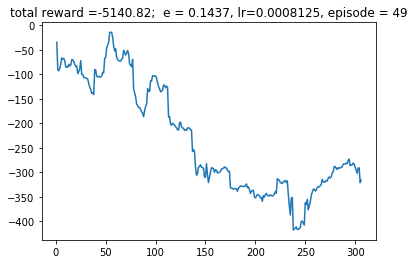

Waiting to train the whole dataset
action0:  148 
action1:  424 
action2:  1408
DONE, lets roll!!
92.553
More than 35 on candle 117
More than 35 on candle 212
More than 35 on candle 1576
More than 35 on candle 1675


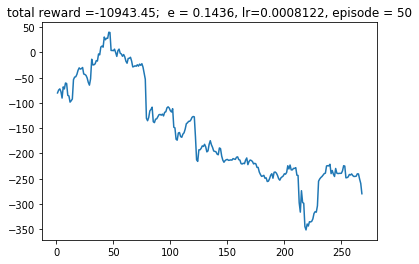

Waiting to train the whole dataset
action0:  191 
action1:  326 
action2:  1463
DONE, lets roll!!
92.619
More than 35 on candle 115
More than 35 on candle 219
More than 35 on candle 512
More than 35 on candle 912
More than 35 on candle 1588


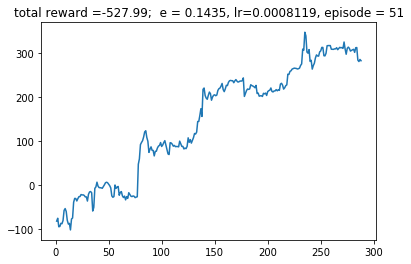

Waiting to train the whole dataset
action0:  108 
action1:  659 
action2:  1213
DONE, lets roll!!
95.919
More than 35 on candle 240
More than 35 on candle 511
More than 35 on candle 704
More than 35 on candle 890
More than 35 on candle 910
More than 35 on candle 984


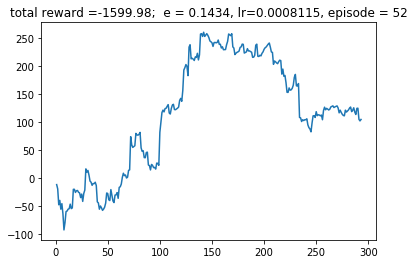

Waiting to train the whole dataset
action0:  196 
action1:  576 
action2:  1208
DONE, lets roll!!
91.82
More than 35 on candle 518
More than 35 on candle 1489
More than 35 on candle 1684


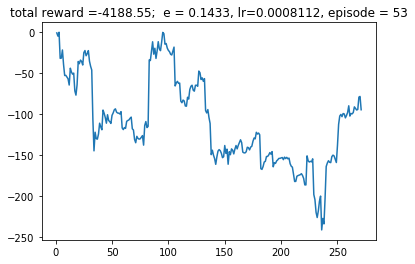

Waiting to train the whole dataset
action0:  158 
action1:  242 
action2:  1580
DONE, lets roll!!
90.694
More than 35 on candle 124
More than 35 on candle 504
More than 35 on candle 1571
More than 35 on candle 1594


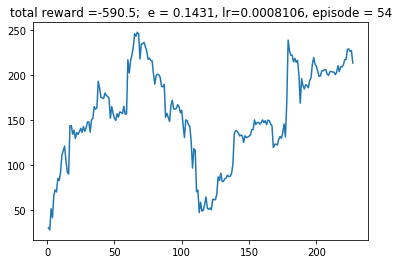

Waiting to train the whole dataset
action0:  112 
action1:  993 
action2:  875
DONE, lets roll!!
109.624
More than 35 on candle 19
More than 35 on candle 879
More than 35 on candle 905
More than 35 on candle 1556


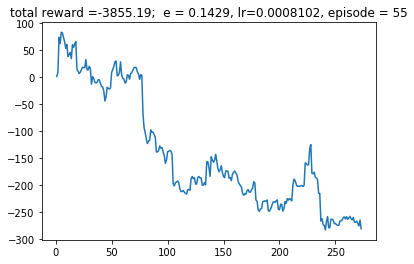

Waiting to train the whole dataset
action0:  114 
action1:  768 
action2:  1098
DONE, lets roll!!
96.912
More than 35 on candle 211
More than 35 on candle 231
More than 35 on candle 506
More than 35 on candle 904


In [ ]:
env = Trevor(Dataframe())
state_size = (NUMBER_OF_SAMPLES, 9)
action_size = 3
batch_size = 128 #32
agent = DQNAgent(state_size, action_size, batch_size)

#agent.save("./save/cartpole-ddqn.h5")
agent.load("./save/cartpole-ddqn.h5")

closed = False
run = False

for e in range(EPISODES):
    state = env.reset()
    strt = t_lib.time()
    
    akce0 = 0
    akce1 = 0
    akce2 = 0
    
    for time in range(env.df.lenght):
        action, random_action = agent.act(state)

        if action > 3 or action < 0:
            print('Got action ' + action)
            continue

        next_state, reward, closed, _ = env.step(action)

        if not isinstance(next_state, np.ndarray) or not(state, np.ndarray):
            print(next_state)
            print('NOT NUMPY!!')
            continue

        agent.memorize(state=state, action=action, reward=reward, next_state=next_state, done=closed)
        state = next_state
        
        """
        print(f'Actual reward = {round(reward, 1)},\t total reward = {round(env.total_reward, 1)},'
              f'\t action = {action}, \t trade_counter = {round(env.trade_counter, 1)}, '
              f'\t pip_counter = {round(env.closed_counter, 1)}'
              f'\t random_action = {random_action}'
              f'\t candle_number = {time}')
        """
        if action == 0:
            akce0 += 1
        if action == 1:
            akce1 += 1
        if action == 2:
            akce2 += 1
        
        # print("Actual reward = {}\t, total reward = {},\t action = {}\t trade_counter = {}\t pip_counter = {}".format(round(reward, 1), round(env.total_reward, 1), action, round(env.trade_counter, 1), round(env.closed_counter, 1)))
        if closed and reward > osmdesat * TIMES_FACTOR:
            agent.update_target_model()
            """
            print("episode: {}/{}, score: {}, e: {}, lr: {}"
                  .format(e, EPISODES, time, round(agent.epsilon, 2)), round(agent.learning_rate, 2))
            """
            print('More than {} on candle {}'.format(osmdesat, time))
        
        if len(agent.memory) > batch_size:
            # agent.replay(batch_size)
            if not run:
                thr_list = [Thread(target=agent.replay) for _ in range(1)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                    
                thr_list = [Thread(target=agent.train_from_iterations) for _ in range(4)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                
                run = True
                
    # clear_output()
    env.plot(title='total reward ={};  e = {}, lr={}, episode = {}'.format(round(env.total_reward, 2), round(agent.epsilon, 4), round(agent.learning_rate, 7), e))
    env.reset_closed_list()
    print('Waiting to train the whole dataset')
    print("action0: ", akce0,"\naction1: ", akce1,"\naction2: ", akce2)
    while not len(agent.sample_memory) == 0:
        pass
    agent.set_learning_rate()
    print('DONE, lets roll!!')
    agent.save("./save/cartpole-ddqn.h5")
    print(round(t_lib.time() - strt, 3))